In [2]:
# load Boston dataset
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# normalize data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [3]:
# build network
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
# train model with k-fold validation (due to small dataset n=404)
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)

    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
Epoch 1/500


2023-03-01 11:30:11.360310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-01 11:30:12.913090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


303/303 - 2s - loss: 186.1449 - mae: 10.3700 - val_loss: 42.3364 - val_mae: 4.4487 - 2s/epoch - 6ms/step
Epoch 2/500
303/303 - 1s - loss: 32.1714 - mae: 3.9194 - val_loss: 26.2279 - val_mae: 3.4007 - 1s/epoch - 5ms/step
Epoch 3/500
303/303 - 2s - loss: 22.5967 - mae: 3.1617 - val_loss: 21.7203 - val_mae: 3.0260 - 2s/epoch - 5ms/step
Epoch 4/500
303/303 - 2s - loss: 18.3188 - mae: 2.7964 - val_loss: 16.9311 - val_mae: 2.7840 - 2s/epoch - 5ms/step
Epoch 5/500
303/303 - 1s - loss: 16.1843 - mae: 2.7079 - val_loss: 15.4753 - val_mae: 2.5567 - 1s/epoch - 5ms/step
Epoch 6/500
303/303 - 1s - loss: 14.8046 - mae: 2.4821 - val_loss: 13.7621 - val_mae: 2.2277 - 1s/epoch - 5ms/step
Epoch 7/500
303/303 - 1s - loss: 14.5270 - mae: 2.4889 - val_loss: 15.6817 - val_mae: 2.4517 - 1s/epoch - 5ms/step
Epoch 8/500
303/303 - 1s - loss: 14.0041 - mae: 2.4294 - val_loss: 13.8508 - val_mae: 2.6258 - 1s/epoch - 5ms/step
Epoch 9/500
303/303 - 1s - loss: 13.9042 - mae: 2.3719 - val_loss: 12.9113 - val_mae: 2.44

2023-03-01 11:42:03.700187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-01 11:42:05.102050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


303/303 - 2s - loss: 207.6075 - mae: 10.6337 - val_loss: 31.4963 - val_mae: 4.3384 - 2s/epoch - 6ms/step
Epoch 2/500
303/303 - 1s - loss: 35.9577 - mae: 4.0659 - val_loss: 16.3049 - val_mae: 3.0356 - 1s/epoch - 5ms/step
Epoch 3/500
303/303 - 1s - loss: 22.9501 - mae: 3.2370 - val_loss: 14.3544 - val_mae: 2.7490 - 1s/epoch - 5ms/step
Epoch 4/500
303/303 - 1s - loss: 18.6286 - mae: 2.8382 - val_loss: 12.6714 - val_mae: 2.5761 - 1s/epoch - 5ms/step
Epoch 5/500
303/303 - 1s - loss: 16.3379 - mae: 2.6779 - val_loss: 11.1440 - val_mae: 2.5173 - 1s/epoch - 5ms/step
Epoch 6/500
303/303 - 1s - loss: 14.3512 - mae: 2.4533 - val_loss: 12.6986 - val_mae: 2.6925 - 1s/epoch - 5ms/step
Epoch 7/500
303/303 - 1s - loss: 14.1912 - mae: 2.3990 - val_loss: 11.7531 - val_mae: 2.7351 - 1s/epoch - 5ms/step
Epoch 8/500
303/303 - 1s - loss: 12.7483 - mae: 2.3739 - val_loss: 11.7268 - val_mae: 2.6081 - 1s/epoch - 5ms/step
Epoch 9/500
303/303 - 2s - loss: 11.9050 - mae: 2.2075 - val_loss: 10.4403 - val_mae: 2.49

2023-03-01 11:54:15.738567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-01 11:54:17.312838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


303/303 - 2s - loss: 193.3573 - mae: 10.2644 - val_loss: 37.4907 - val_mae: 4.3516 - 2s/epoch - 7ms/step
Epoch 2/500
303/303 - 1s - loss: 31.5306 - mae: 3.9111 - val_loss: 26.4143 - val_mae: 3.4686 - 1s/epoch - 5ms/step
Epoch 3/500
303/303 - 1s - loss: 21.2107 - mae: 3.1307 - val_loss: 23.1462 - val_mae: 3.1703 - 1s/epoch - 5ms/step
Epoch 4/500
303/303 - 1s - loss: 17.0932 - mae: 2.8684 - val_loss: 20.8554 - val_mae: 2.9202 - 1s/epoch - 5ms/step
Epoch 5/500
303/303 - 1s - loss: 14.5075 - mae: 2.6096 - val_loss: 21.4192 - val_mae: 2.9339 - 1s/epoch - 5ms/step
Epoch 6/500
303/303 - 1s - loss: 12.8817 - mae: 2.4769 - val_loss: 18.6961 - val_mae: 2.7247 - 1s/epoch - 5ms/step
Epoch 7/500
303/303 - 1s - loss: 12.4739 - mae: 2.4170 - val_loss: 19.3076 - val_mae: 2.7473 - 1s/epoch - 5ms/step
Epoch 8/500
303/303 - 2s - loss: 11.1095 - mae: 2.3156 - val_loss: 18.0219 - val_mae: 2.7594 - 2s/epoch - 5ms/step
Epoch 9/500
303/303 - 2s - loss: 10.4263 - mae: 2.1996 - val_loss: 20.1517 - val_mae: 3.04

2023-03-01 12:06:13.207978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-03-01 12:06:14.628631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


303/303 - 2s - loss: 173.4382 - mae: 9.9189 - val_loss: 72.6929 - val_mae: 5.9559 - 2s/epoch - 6ms/step
Epoch 2/500
303/303 - 1s - loss: 30.5312 - mae: 3.7449 - val_loss: 41.0751 - val_mae: 4.2147 - 1s/epoch - 5ms/step
Epoch 3/500
303/303 - 1s - loss: 20.1940 - mae: 3.0477 - val_loss: 29.4075 - val_mae: 3.4615 - 1s/epoch - 5ms/step
Epoch 4/500
303/303 - 1s - loss: 16.5823 - mae: 2.6217 - val_loss: 27.0589 - val_mae: 3.2849 - 1s/epoch - 5ms/step
Epoch 5/500
303/303 - 1s - loss: 14.8069 - mae: 2.4646 - val_loss: 25.2681 - val_mae: 3.2620 - 1s/epoch - 5ms/step
Epoch 6/500
303/303 - 1s - loss: 13.6591 - mae: 2.3782 - val_loss: 22.9928 - val_mae: 2.8576 - 1s/epoch - 5ms/step
Epoch 7/500
303/303 - 1s - loss: 12.4594 - mae: 2.2846 - val_loss: 26.6718 - val_mae: 3.0357 - 1s/epoch - 5ms/step
Epoch 8/500
303/303 - 1s - loss: 12.5126 - mae: 2.2388 - val_loss: 24.8378 - val_mae: 3.0818 - 1s/epoch - 5ms/step
Epoch 9/500
303/303 - 1s - loss: 12.4357 - mae: 2.2094 - val_loss: 25.0675 - val_mae: 3.067

In [7]:
# compute average mae (mean average error) for each epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                                        for i in range(num_epochs)]

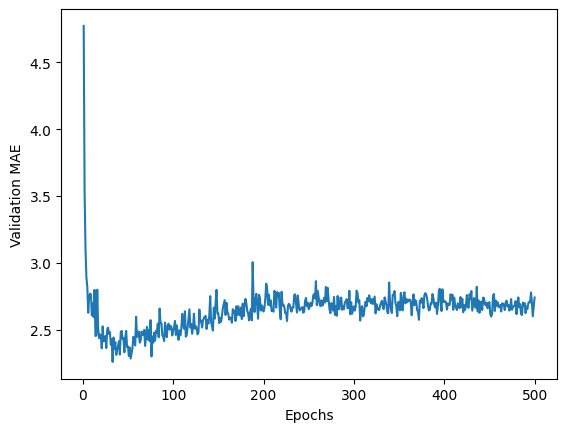

In [8]:
# plot validation score (mae) per epoch
import matplotlib.pyplot as plt\

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

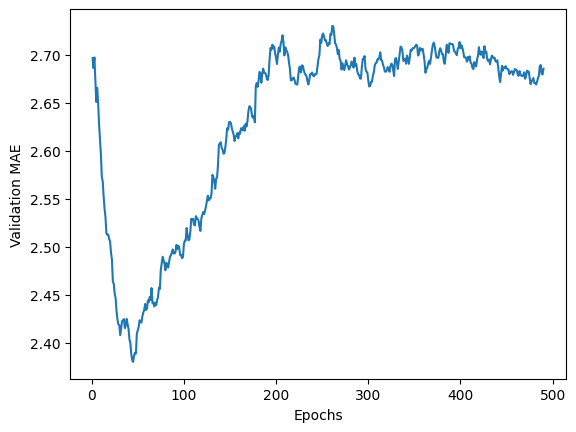

In [9]:
# exclude first 10 points and smooth plot for clarity
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append((previous * factor) + (point * (1 - factor)))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [15]:
# train final network with tuned hyperparameters (num_epochs=80)
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2023-03-01 12:22:30.952082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step - loss: 18.2534 - mae: 2.7116


2023-03-01 12:22:42.210436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
